In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=ValueError)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (make sure to update the path if needed)
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'],dayfirst=True)

# Rename and set date as index
df.columns = ['Date', 'USD_AUD']
df.set_index('Date', inplace=True)
# Resample to monthly average to reduce noise
monthly = df['USD_AUD'].resample('M').mean().asfreq('M')

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   USD_AUD  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


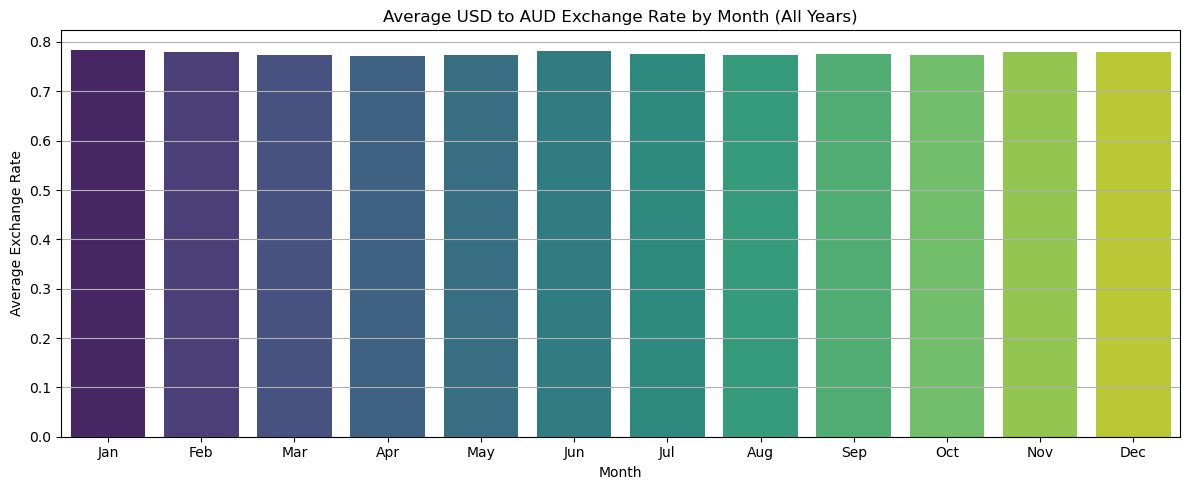

In [53]:
# Extract month and year for grouping
df['Month'] = df.index.month
df['Year'] = df.index.year

# Calculate average exchange rate by month across all years
monthly_trend = df.pivot_table(values='USD_AUD', index='Month', aggfunc='mean')

# Plot average exchange rate by month
plt.figure(figsize=(12, 5))
sns.barplot(x=monthly_trend.index, y='USD_AUD', data=monthly_trend, palette='viridis')

# Customize plot
plt.title('Average USD to AUD Exchange Rate by Month (All Years)')
plt.xlabel('Month')
plt.ylabel('Average Exchange Rate')
plt.xticks(ticks=range(0, 12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.tight_layout()
plt.show()

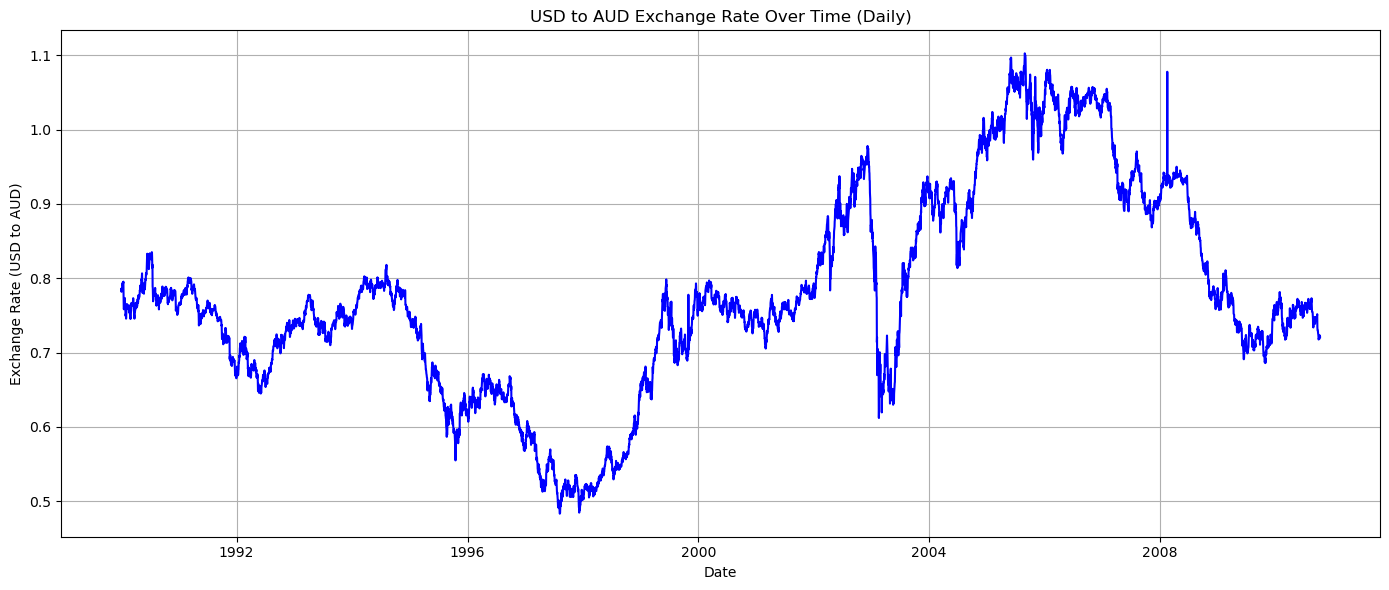

In [54]:
# Plot 1: Daily Exchange Rate
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Date', y='USD_AUD', color='blue')
plt.title('USD to AUD Exchange Rate Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.grid(True)
plt.tight_layout()
plt.show()

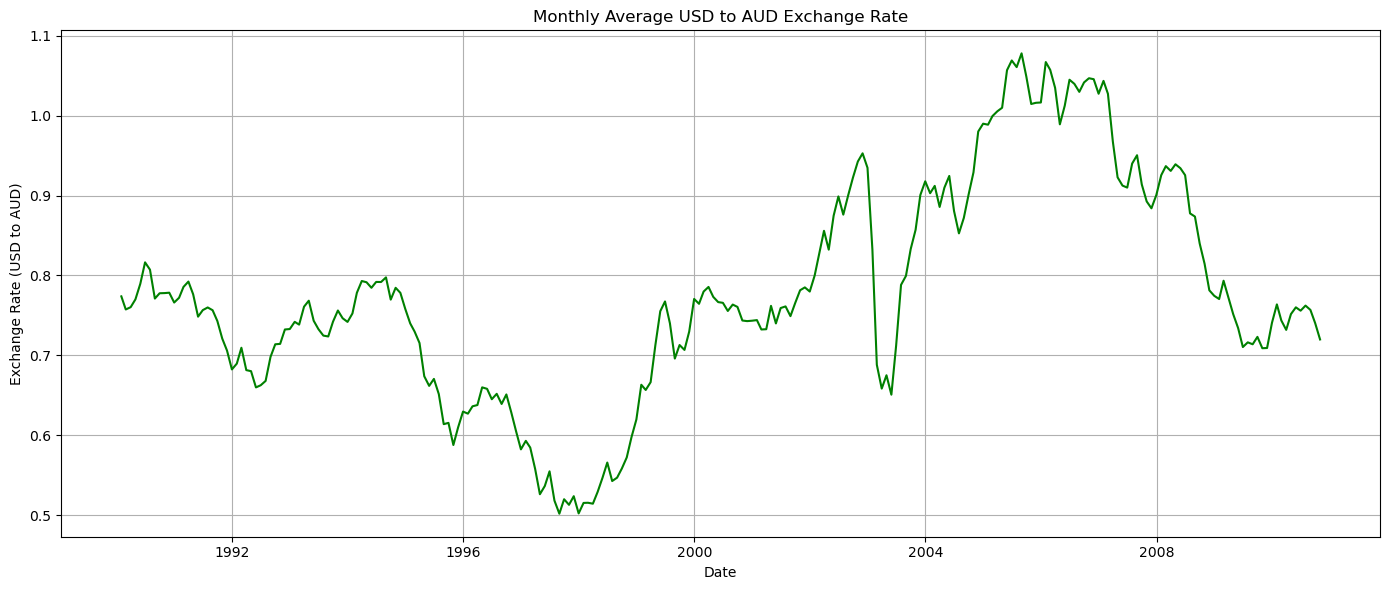

In [55]:
# Resample to monthly average to smooth out daily fluctuations
monthly_avg = df['USD_AUD'].resample('M').mean()

# Plot 2: Monthly Average Exchange Rate
plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly, color='green')
plt.title('Monthly Average USD to AUD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.grid(True)
plt.tight_layout()
plt.show()

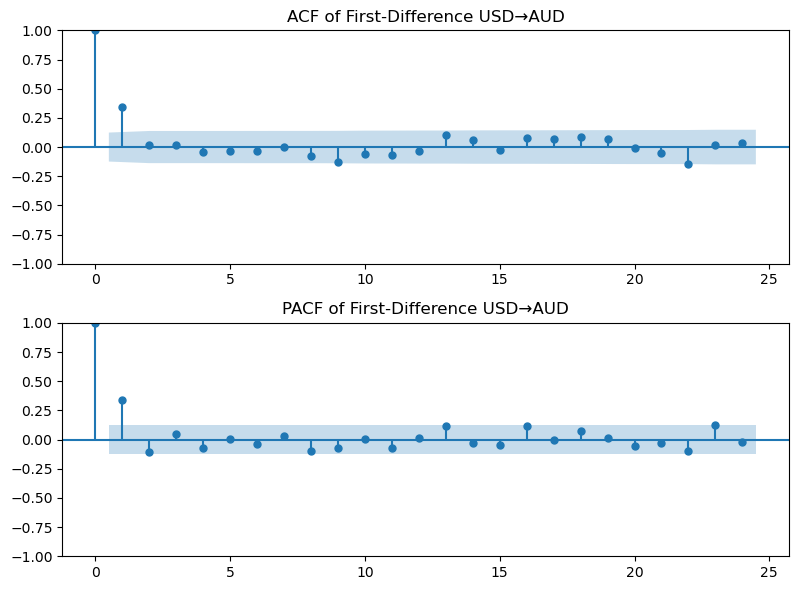

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ts_diff = monthly.diff().dropna()

# 4. Plotting
fig, axes = plt.subplots(2, 1, figsize=(8,6))

# ACF
plot_acf(ts_diff, lags=24, ax=axes[0], title='ACF of First‑Difference USD→AUD')

# PACF
plot_pacf(ts_diff, lags=24, ax=axes[1], title='PACF of First‑Difference USD→AUD', method='ywm')

plt.tight_layout()
plt.show()

       order           AIC           BIC
2  (1, 1, 0) -56104.318870 -56090.450487
3  (0, 1, 1) -56102.753413 -56088.885030
0  (1, 1, 1) -56102.321673 -56081.519098
1  (2, 1, 1) -56100.315876 -56072.579109
4  (2, 1, 2) -56100.135330 -56065.464372


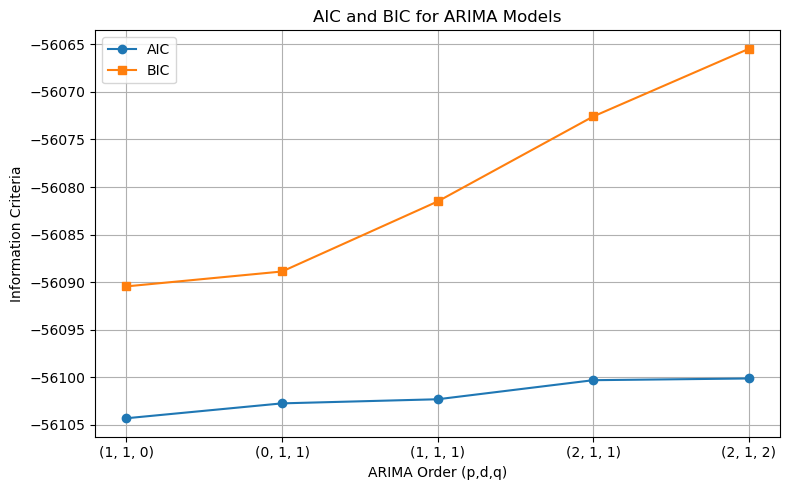

In [60]:
from statsmodels.tsa.arima.model import ARIMA  # Make sure this import works
import warnings
warnings.filterwarnings("ignore")

# Use the relevant column — change 'rate' to your actual column name
ts = df['USD_AUD']

# First-difference the data (d=1)
ts_diff = ts.diff().dropna()

# Define candidate ARIMA models to evaluate
models = [(1,1,1), (2,1,1), (1,1,0), (0,1,1), (2,1,2)]

# Store results
results = []

for order in models:
    try:
        model = ARIMA(ts, order=order)
        model_fit = model.fit()
        results.append({
            'order': order,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic
        })
    except Exception as e:
        print(f"Model {order} failed: {e}")

# Create a DataFrame to compare
results_df = pd.DataFrame(results).sort_values(by='AIC')
print(results_df)

# Optional: visualize
plt.figure(figsize=(8, 5))
plt.plot(results_df['order'].astype(str), results_df['AIC'], marker='o', label='AIC')
plt.plot(results_df['order'].astype(str), results_df['BIC'], marker='s', label='BIC')
plt.title('AIC and BIC for ARIMA Models')
plt.xlabel('ARIMA Order (p,d,q)')
plt.ylabel('Information Criteria')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [61]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
# Fit ARIMA(0,1,1) to the full series
arima_model = ARIMA(monthly, order=(1,1,0))
arima_res = arima_model.fit()
print(arima_res.summary())


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                  250
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 591.664
Date:                Sat, 17 May 2025   AIC                          -1179.328
Time:                        17:36:46   BIC                          -1172.293
Sample:                    01-31-1990   HQIC                         -1176.497
                         - 10-31-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3399      0.045      7.561      0.000       0.252       0.428
sigma2         0.0005   3.66e-05     13.810      0.000       0.000       0.001
Ljung-Box (L1) (Q):                   0.34   Jarque-

In [ ]:
#ARIMA(1,1,0) has the lowest AIC and BIC, meaning:

# It fits the data well.
# It’s relatively simple (parsimonious).
# It is statistically favored over more complex models like ARIMA(2,1,2).

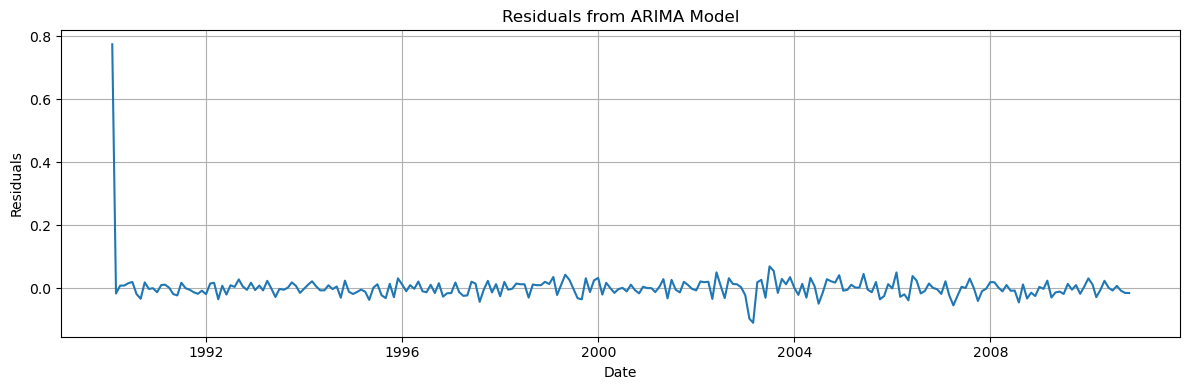

In [62]:
# Get residuals from the fitted model
residuals = arima_res.resid

# 1. Residual Time Series Plot
plt.figure(figsize=(12, 4))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)
plt.tight_layout()
plt.show()

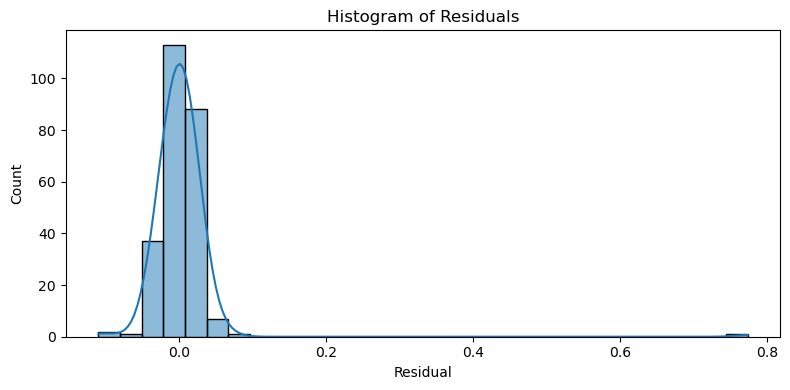

In [63]:
# 2. Histogram + KDE
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

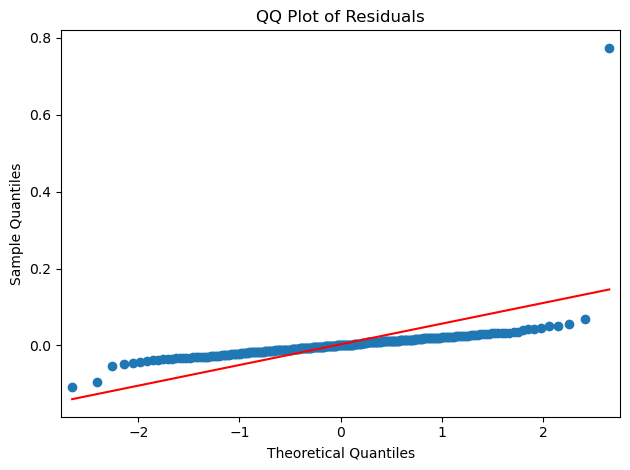

In [65]:
# 3. QQ Plot (normality check)
from statsmodels.graphics.gofplots import qqplot
plt.figure(figsize=(6, 6))
qqplot(residuals, line='s')
plt.title('QQ Plot of Residuals')
plt.tight_layout()
plt.show()


In [66]:
#Randomness:

# The residuals appear randomly scattered around zero (after the first few values), 
# which is a strong indication that the ARIMA model has successfully captured the patterns in the time series.

# No Apparent Trends:

# There's no obvious upward or downward trend.
# Residuals don't show seasonality or autocorrelation visually.

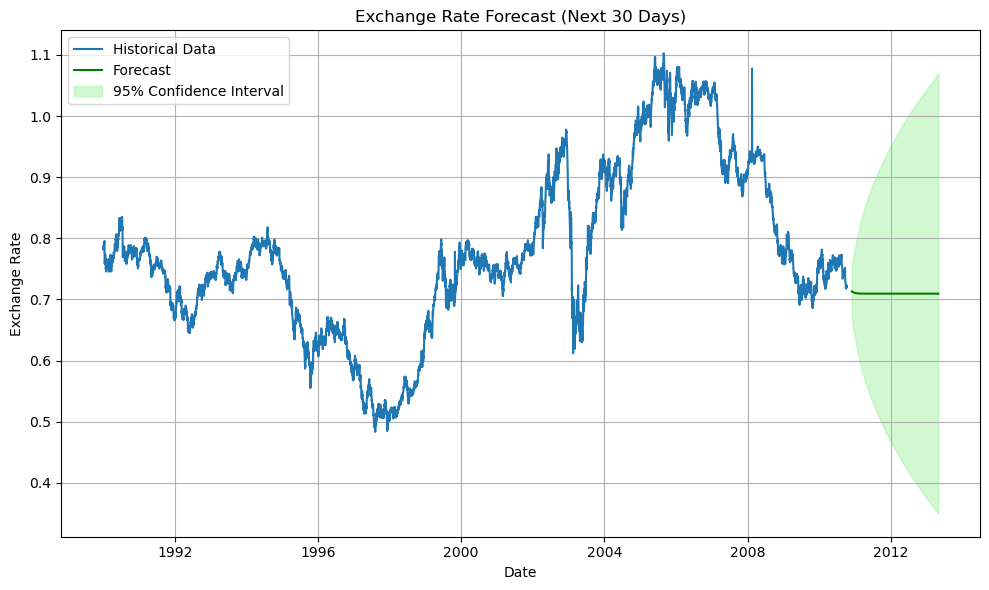

In [75]:
#Forecasting

# Forecast the next 30 days (change steps as needed)
forecast_steps = 30
forecast_result = arima_res.get_forecast(steps=forecast_steps)

# Get predicted mean and confidence intervals
forecast_arima = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a forecast plot
plt.figure(figsize=(10, 6))
plt.plot(ts, label='Historical Data')
plt.plot(forecast_arima.index, forecast_arima, label='Forecast', color='green')
plt.fill_between(forecast_arima.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightgreen', alpha=0.4, label='95% Confidence Interval')
plt.title('Exchange Rate Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import itertools


# Train-Test Split (80-20)
series = df['USD_AUD']
split_idx = int(len(series) * 0.8)
train, test = series[:split_idx], series[split_idx:]

# Candidate model configurations
models = [
    {'trend': None, 'seasonal': None, 'seasonal_periods': None, 'name': 'Simple'},
    {'trend': 'add', 'seasonal': None, 'seasonal_periods': None, 'name': 'Holt Linear'},
    {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12, 'name': 'Holt-Winters Additive'},
    {'trend': 'add', 'seasonal': 'mul', 'seasonal_periods': 12, 'name': 'Holt-Winters Multiplicative'},
]

results = []

# Grid search across models
for model_cfg in models:
    try:
        model = ExponentialSmoothing(
            train,
            trend=model_cfg['trend'],
            seasonal=model_cfg['seasonal'],
            seasonal_periods=model_cfg['seasonal_periods'],
            initialization_method='estimated'
        )
        fitted = model.fit(optimized=True)
        forecast = fitted.forecast(len(test))
        mse = mean_squared_error(test, forecast)
        aic = fitted.aic

        results.append({
            'Model': model_cfg['name'],
            'AIC': aic,
            'MSE': mse,
            'FittedModel': fitted
        })
    except Exception as e:
        print(f"{model_cfg['name']} failed: {e}")

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values(by='AIC')
print(results_df[['Model', 'AIC', 'MSE']])




                         Model           AIC       MSE
0                       Simple -62659.336805  0.042171
1                  Holt Linear -62655.290061  0.048437
2        Holt-Winters Additive -62626.283524  0.057268
3  Holt-Winters Multiplicative -62624.741336  0.056092


In [71]:
# Best model selection
best_model = results_df.iloc[0]['FittedModel']
best_name = results_df.iloc[0]['Model']
forecast = best_model.forecast(len(test))
print(best_model)

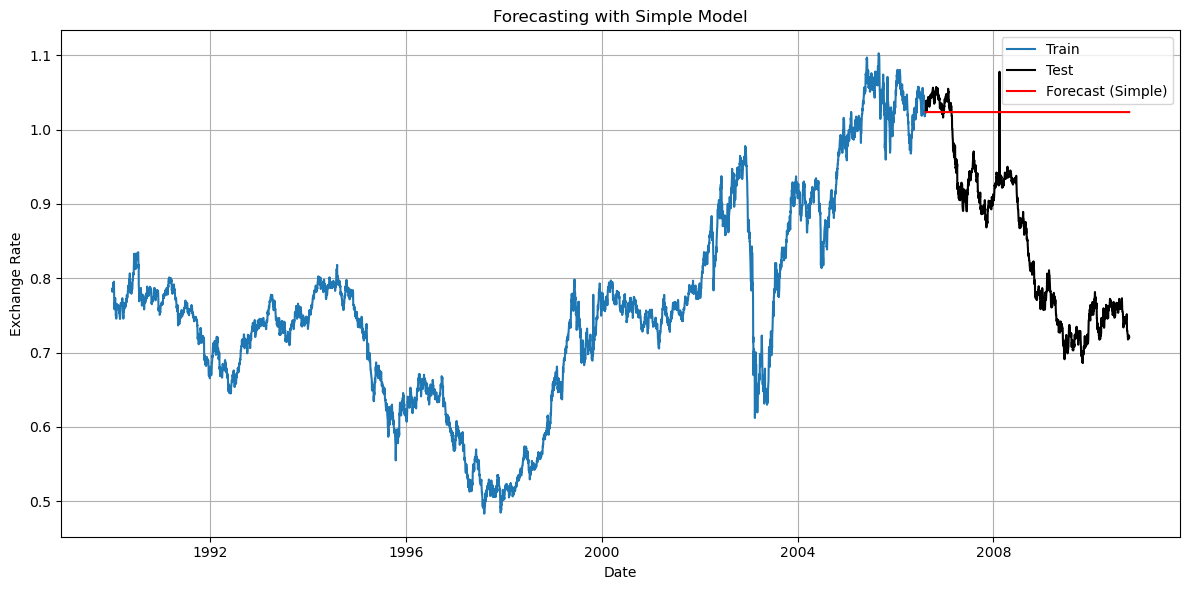

In [72]:
# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='black')
plt.plot(test.index, forecast, label=f'Forecast ({best_name})', color='red')
plt.title(f'Forecasting with {best_name} Model')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [84]:
# Determine forecast horizon
forecast_horizon = len(test)

# Generate forecasts
forecast_arima = arima_res.get_forecast(steps=forecast_horizon)
forecast_arima_values = forecast_arima.predicted_mean
#forecast = forecast.predicted_mean
# Now both arrays should match in length
print(len(test), len(forecast_arima_values),len(forecast))  # should both print the same number


1518 1518 1518


In [87]:
#Evaluation and Comparison

from sklearn.metrics import mean_absolute_error, mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Forecasts: `forecast_arima`, `forecast_ets` are arrays/series with test index
# Test set: `test` is your ground truth

# ARIMA Metrics
mae_arima = mean_absolute_error(test, forecast_arima_values)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima_values))
mape_arima = mean_absolute_percentage_error(test, forecast_arima_values)

# ETS Metrics
mae_ets = mean_absolute_error(test, forecast)
rmse_ets = np.sqrt(mean_squared_error(test, forecast))
mape_ets = mean_absolute_percentage_error(test, forecast)

# Print all metrics
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'ETS'],
    'MAE': [mae_arima, mae_ets],
    'RMSE': [rmse_arima, rmse_ets],
    'MAPE (%)': [mape_arima, mape_ets]
})

print(metrics_df)


   Model       MAE      RMSE   MAPE (%)
0  ARIMA  0.141247  0.178317  15.264641
1    ETS  0.177638  0.205356  22.788835


In [88]:
# Forecast Accuracy (Lower is Better):

# ARIMA outperforms ETS across all three metrics:
# MAE: ARIMA forecasts are closer to the actual values on average.
# RMSE: Lower variance in ARIMA's prediction errors.
# MAPE: ARIMA is ~7.5% better in percentage error terms, which is substantial.

# Model Stability:

# ARIMA shows more stable and reliable forecasting performance.
# ETS (Exponential Smoothing) lags behind, possibly due to the data's characteristics not favoring seasonal trend smoothing.